# TER - Extraction de texte et arXiv DOI Version Fonctionelle

## Objectifs de ce Notebook?

Objectifs:
- parser un article scientifique au format PDF en texte
- extraire de ce texte des informations utiles (articles cités, leur DOI arXiv, leurs auteurs)
- générer le graphe de citation depuis l'article source
- générer datasets avec contextes de citations 

## Données

Article source: /work/articletest.pdf

### Prérequis:

In [1]:
# coding=utf8

!pip install PyPDF2==3.0.1 
!pip install arxiv==1.4.3

import PyPDF2
import re
import pandas as pd
import arxiv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 KB 3.8 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6067 sha256=d642452448b1365186b2a3b20df3e42f1ad8acab6116477dfcfbf5c8cc3a9a9e
  Stored in directory: /root/.cache/pip/wheels/65/7a/a7/78c287f64e401255dff4c13fdbc672fed5efbfd21c530114e1
Successfully built sgmllib3k
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


#### Parse l'article en PDF vers TEXTE:

In [2]:
with open('articletest.pdf', 'rb') as file:
    # créer un objet pdf
    pdf = PyPDF2.PdfReader(file)
     #extraire le texte de chaque page
    t=''
    for page in range (len(pdf.pages)): 
        t+=pdf.pages[page].extract_text()
        #print(pdf.pages[page].extract_text())
    print(t) #t stocke notre texte extrait du PDF

consider ( salience ) is whether the linked document
can offer new, useful knowledge that may not be ob-
vious to the current LM. Hyperlinks are potentially
more advantageous than lexical similarity links in
this regard: LMs are shown to be good at recogniz-
ing lexical similarity (Zhang et al., 2020), and hyper-
links can bring in useful background knowledge thatmay not be obvious via lexical similarity alone (Asai
et al., 2020). Indeed, we empirically ﬁnd that using
hyperlinks yields a more performant LM (§5.5).
Diversity. In the document graph, some docu-
ments may have a very high in-degree (e.g., many
incoming hyperlinks, like the “United States” page
of Wikipedia), and others a low in-degree. If we uni-
formly sample from the linked documents for each
anchor segment, we may include documents of high
in-degree too often in the overall training data, los-
ing diversity. To adjust so that all documents appear
with a similar frequency in training, we sample a
linked document with pro

#### On match les auteurs dans l'article pour ensuite les matcher avec les arXiv_ID présent dans les references:

In [3]:
new_df = pd.DataFrame(columns=['Author'])


regex = r"((?:[A-Z][A-Za-z'`-]+\s*et al.*\s*.\d{4}))|((?:[A-Z][a-z]*\s+)(?:[a-z]*\s*)(?:[A-Z][a-z]*)(?:,\s*)(?:\d{4}))|(?:[A-Z][a-z]*\s+)(?:et al.?)(?:,\s)(?:\d{4})|((?:[A-Z][a-z]*\s+)(?:al.?)(?:,\s*)(?:\d{4}))"

test_str = t

matches = re.finditer(regex, test_str, re.MULTILINE)

for matchNum, match in enumerate(matches, start=1):
    
    row = [match.group()]
    new_df.loc[len(new_df)] = row

#new_df

#### Formatage du DataFrame précedent:

In [4]:
new_df = new_df['Author'].str.split(';', expand=True).stack().reset_index(level=1, drop=True)
new_df = pd.DataFrame(new_df, columns=['Author'])
new_df['Author'] = new_df['Author'].str.replace(r'\(\d{4}.*\)', '')
new_df['Author'] = new_df['Author'].str.rstrip()

/tmp/ipykernel_87/136082988.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  new_df['Author'] = new_df['Author'].str.replace(r'\(\d{4}.*\)', '')


In [5]:
new_df

,Author
0,"Devlin et al., 2019"
0,"Brown et al., 2020"
1,"Bommasani\net al., 2021"
2,"Devlin\net al., 2019"
3,"Petroni et al.,\n2019"
...,...
86,Ansari et al. 2015)Doc B: ... Deep vein thromb...
87,Ansari et al. (2015
88,Piovella et al.\n(2002
89,"Sheng et al., 2020"


#### Match les arXiv_ID dans l'article:

In [6]:
regex = r"(arXiv:\d+\.\d+)"

arXiv_doi = pd.DataFrame(columns=['arXiv DOI'])

test_str = t

matches = re.finditer(regex, test_str)

for matchNum, match in enumerate(matches, start=1):
    print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
    row = [match.group(1)]
    arXiv_doi.loc[len(arXiv_doi)] = row

arXiv_doi['arXiv DOI'] = arXiv_doi['arXiv DOI'].str.replace('arXiv:', '')
#arXiv_doi
      

Match 1 was found at 6038-6054: arXiv:2203.15827
Match 2 was found at 52005-52021: arXiv:2107.06955
Match 3 was found at 54827-54843: arXiv:2108.07258
Match 4 was found at 55969-55985: arXiv:2101.00406
Match 5 was found at 58049-58065: arXiv:1704.05179
Match 6 was found at 58898-58914: arXiv:2007.15779
Match 7 was found at 63164-63180: arXiv:2110.04541
Match 8 was found at 64211-64227: arXiv:1907.11692
Match 9 was found at 65502-65518: arXiv:2012.14610
Match 10 was found at 68383-68399: arXiv:1908.08962
Match 11 was found at 69958-69974: arXiv:2201.05966
Match 12 was found at 71869-71885: arXiv:1905.07129


#### Retrouver le nom de l'article et le nom des auteurs avec les DOI en utilisant la bibliotheque arxiv:

In [7]:
# Initialiser une DataFrame pour stocker les informations sur les auteurs et les articles
arXiv_info = pd.DataFrame(columns=['DOI','Title', 'Author(s)','Abstract'])

# Boucle à travers les informations stockées dans la DataFrame "arXiv_doi"
for i, row in arXiv_doi.iterrows():
    arXiv_id = row['arXiv DOI']
    #print(arXiv_id)
    try:
        # Utiliser la bibliothèque "arxiv" pour obtenir les informations sur l'article
        query = arxiv.Search(arXiv_id)
        paper = next(query.results())

        title = paper.title
        
        authors = ', '.join([author.name for author in paper.authors])
        #authors = paper.authors[0]
        abstract = paper.summary
        
        #Ajouter les informations à la DataFrame "arXiv_info"
        arXiv_info.loc[i] = [arXiv_id, title, authors,abstract]
    except:
        print(f"Erreur pour retrouver les informations de {arXiv_id}")

#arXiv_info

In [8]:
arXiv_info

,DOI,Title,Author(s),Abstract
0,2203.15827,LinkBERT: Pretraining Language Models with Doc...,"Michihiro Yasunaga, Jure Leskovec, Percy Liang",Language model (LM) pretraining can learn vari...
1,2107.06955,HTLM: Hyper-Text Pre-Training and Prompting of...,"Armen Aghajanyan, Dmytro Okhonko, Mike Lewis, ...","We introduce HTLM, a hyper-text language model..."
2,2108.07258,On the Opportunities and Risks of Foundation M...,"Rishi Bommasani, Drew A. Hudson, Ehsan Adeli, ...",AI is undergoing a paradigm shift with the ris...
3,2101.00406,CDLM: Cross-Document Language Modeling,"Avi Caciularu, Arman Cohan, Iz Beltagy, Matthe...",We introduce a new pretraining approach geared...
4,1704.05179,SearchQA: A New Q&A Dataset Augmented with Con...,"Matthew Dunn, Levent Sagun, Mike Higgins, V. U...","We publicly release a new large-scale dataset,..."
5,2007.15779,Domain-Specific Language Model Pretraining for...,"Yu Gu, Robert Tinn, Hao Cheng, Michael Lucas, ...","Pretraining large neural language models, such..."
6,2110.04541,The Inductive Bias of In-Context Learning: Ret...,"Yoav Levine, Noam Wies, Daniel Jannai, Dan Nav...",Pretraining Neural Language Models (NLMs) over...
7,1907.11692,RoBERTa: A Robustly Optimized BERT Pretraining...,"Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du,...",Language model pretraining has led to signific...
8,2012.14610,UniK-QA: Unified Representations of Structured...,"Barlas Oguz, Xilun Chen, Vladimir Karpukhin, S...",We study open-domain question answering with s...
9,1908.08962,Well-Read Students Learn Better: On the Import...,"Iulia Turc, Ming-Wei Chang, Kenton Lee, Kristi...",Recent developments in natural language repres...


#### Extraction du contexte de citation avec le nom du premier auteur dans le texte:

In [9]:
df_author_context = pd.DataFrame(columns=['Author','context_left','context_right'])

for index, row in new_df.iterrows():
    authors = row['Author']
    first_author = authors.split(',')[0]
    author_index = t.find(first_author)
    if author_index != -1:
        author_start = max(0, author_index - 30 * len(first_author))
        author_end = min(len(t), author_index + 30 * len(first_author))
        #context = t[author_start:author_end]
        #print("Le nom du premier auteur '{}' a été trouvé dans le texte pour l'article '{}' avec le DOI '{}' avec le contexte suivant :\n{}".format(first_author, title, doi, context))
        context_left = t[author_start:author_index]
        context_right = t[author_index:author_end]
        df_author_context = df_author_context.append({'Author': first_author, 'context_left': context_left, 'context_right': context_right}, ignore_index=True)

#df_author_context


In [10]:
arXiv_info['First_Author_Last_Name'] = arXiv_info['Author(s)'].apply(lambda x: x.split(',')[0].strip().split(' ')[-1])

#merged_df = pd.merge(df_author_context, arXiv_info, left_on='Author', right_on='Author(s)')
#merged_df
arXiv_info['First_Author_Last_Name']

0       Yasunaga
1     Aghajanyan
2      Bommasani
3      Caciularu
4           Dunn
5             Gu
6         Levine
7            Liu
8           Oguz
9           Turc
10           Xie
11         Zhang
Name: First_Author_Last_Name, dtype: object

#### Formatage du dataframe df_author_context

In [11]:
df_author_context['Author']=df_author_context['Author'].apply(lambda x: x.split()[0])

df_author_context_arXiv_only = df_author_context[df_author_context['Author'].isin(arXiv_info['First_Author_Last_Name'].values)]
df_author_context_arXiv_only = df_author_context_arXiv_only.merge(arXiv_info[['First_Author_Last_Name', 'DOI', 'Title','Abstract']],
                                                                  left_on='Author', right_on='First_Author_Last_Name',
                                                                  how='left')

df_author_context_arXiv_only.drop(df_author_context_arXiv_only.columns[[0,3,5]], axis=1,inplace=True)


df_author_context_arXiv_only= df_author_context_arXiv_only.drop_duplicates(subset='DOI', keep='first')

In [12]:
df_author_context_arXiv_only

,context_left,context_right,DOI,Abstract
0,ur biomedical\nLinkBERT sets new states of the...,"Bommasani\net al., 2021). By performing self-s...",2108.07258,AI is undergoing a paradigm shift with the ris...
1,"us applications, including\nanswering a questi...","Liu et al., 2019; Joshi et al., 2020)\nand do ...",1907.11692,Language model pretraining has led to signific...
2,in both domains.LinkBERT consistently improve...,"Gu et al., 2020) and sets\nnew states of the a...",2007.15779,"Pretraining large neural language models, such..."
3,"arge\ngains for multi-hop reasoning, multi-doc...","Oguz\net al., 2020; Xie et al., 2022) introduc...",2012.14610,We study open-domain question answering with s...
4,"ti-hop reasoning, multi-document\nunderstandin...","Xie et al., 2022) introduce a retrieval\nmodu...",2201.05966,Structured knowledge grounding (SKG) leverages...
5,LM with a retriever that learns to retrieve t...,Caciularu et al. (2021) place doc-\numents (ne...,2101.00406,We introduce a new pretraining approach geared...
6,"es knowledge\nthat spans across documents, whi...",Levine et al. (2021) place sen-\ntences of hig...,2110.04541,Pretraining Neural Language Models (NLMs) over...
7,uestion answering.\nMa et al. (2021) study var...,"Yasunaga et al.,\n2019; Bhagavatula et al., 20...",2203.15827,Language model (LM) pretraining can learn vari...
8,"ers (Qazvinian and Radev, 2008; Yasunaga et al...",Zhang et al. (2019); He et al. (2020);\nWang e...,1905.07129,Neural language representation models such as ...
11,§6). Hy-\nperlinks have a number of advantages...,"Aghajanyan\net al., 2021). To construct the do...",2107.06955,"We introduce HTLM, a hyper-text language model..."


#### Supprimer les arxiv_id en double

In [13]:
df_author_context_arXiv_only= df_author_context_arXiv_only.drop_duplicates(subset='DOI', keep='first')

#### Parse en CSV le dataframe final

In [14]:
df_author_context_arXiv_only.to_csv("df_author_context_arXiv_only.csv", index=False)


## test de fonction qui genere un datastet de contexte pour un article 

In [15]:
import PyPDF2
import re
import pandas as pd
import arxiv

def get_df_author_context_arXiv_only(file_path):
    with open(file_path, 'rb') as file:
        # créer un objet pdf
        pdf = PyPDF2.PdfReader(file)
         #extraire le texte de chaque page
        t=''
        for page in range (len(pdf.pages)): 
            t+=pdf.pages[page].extract_text()
            #print(pdf.pages[page].extract_text())
        print(t) #t stocke notre texte extrait du PDF


    new_df = pd.DataFrame(columns=['Author'])

    regex = r"((?:[A-Z][A-Za-z'`-]+\s*et al.*\s*.\d{4}))|((?:[A-Z][a-z]*\s+)(?:[a-z]*\s*)(?:[A-Z][a-z]*)(?:,\s*)(?:\d{4}))|(?:[A-Z][a-z]*\s+)(?:et al.?)(?:,\s)(?:\d{4})|((?:[A-Z][a-z]*\s+)(?:al.?)(?:,\s*)(?:\d{4}))"

    test_str = t

    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):

        row = [match.group()]
        new_df.loc[len(new_df)] = row


    new_df = new_df['Author'].str.split(';', expand=True).stack().reset_index(level=1, drop=True)
    new_df = pd.DataFrame(new_df, columns=['Author'])
    new_df['Author'] = new_df['Author'].str.replace(r'\(\d{4}.*\)', '')
    new_df['Author'] = new_df['Author'].str.rstrip()


    regex = r"(arXiv:\d+\.\d+)"

    arXiv_doi = pd.DataFrame(columns=['arXiv DOI'])

    test_str = t

    matches = re.finditer(regex, test_str)

    for matchNum, match in enumerate(matches, start=1):
        print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
        row = [match.group(1)]
        arXiv_doi.loc[len(arXiv_doi)] = row

    arXiv_doi['arXiv DOI'] = arXiv_doi['arXiv DOI'].str.replace('arXiv:', '')

    # Initialiser une DataFrame pour stocker les informations sur les auteurs et les articles
    arXiv_info = pd.DataFrame(columns=['DOI','Title', 'Author(s)','Abstract'])

    # Boucle à travers les informations stockées dans la DataFrame "arXiv_doi"
    for i, row in arXiv_doi.iterrows():
        arXiv_id = row['arXiv DOI']
        #print(arXiv_id)
        try:
            # Utiliser la bibliothèque "arxiv" pour obtenir les informations sur l'article
            query = arxiv.Search(arXiv_id)
            paper = next(query.results())

            title = paper.title

            authors = ', '.join([author.name for author in paper.authors])
            #authors = paper.authors[0]
            abstract = paper.summary

            #Ajouter les informations
            arXiv_info = arXiv_info.append({'DOI': arXiv_id,
                                        'Title': title,
                                        'Author(s)': authors,
                                        'Abstract': abstract},
                                        ignore_index=True)
        except Exception as e:
            print(f"Error: {e} - Skipping arXiv ID: {arXiv_id}")
    df_author_context = pd.DataFrame(columns=['Author','context_left','context_right'])

    for index, row in new_df.iterrows():
        authors = row['Author']
    first_author = authors.split(',')[0]
    author_index = t.find(first_author)
    if author_index != -1:
        author_start = max(0, author_index - 30 * len(first_author))
        author_end = min(len(t), author_index + 30 * len(first_author))
        #context = t[author_start:author_end]
        #print("Le nom du premier auteur '{}' a été trouvé dans le texte pour l'article '{}' avec le DOI '{}' avec le contexte suivant :\n{}".format(first_author, title, doi, context))
        context_left = t[author_start:author_index]
        context_right = t[author_index:author_end]
        df_author_context = df_author_context.append({'Author': first_author, 'context_left': context_left, 'context_right': context_right}, ignore_index=True)

    #df_author_context
    arXiv_info['First_Author_Last_Name'] = arXiv_info['Author(s)'].apply(lambda x: x.split(',')[0].strip().split(' ')[-1])
    df_author_context['Author']=df_author_context['Author'].apply(lambda x: x.split()[0])

    df_author_context_arXiv_only = df_author_context[df_author_context['Author'].isin(arXiv_info['First_Author_Last_Name'].values)]
    df_author_context_arXiv_only = df_author_context_arXiv_only.merge(arXiv_info[['First_Author_Last_Name', 'DOI', 'Title','Abstract']],
                                                                  left_on='Author', right_on='First_Author_Last_Name',
                                                                  how='left')

    df_author_context_arXiv_only.drop(df_author_context_arXiv_only.columns[[0,3,5]], axis=1,inplace=True)


    df_author_context_arXiv_only= df_author_context_arXiv_only.drop_duplicates(subset='DOI', keep='first')

    return df_author_context_arXiv_only

## Fonction pour generer un graphe de citation sur un article 

In [16]:
!pip install networkx==3.0
import networkx as nx
import matplotlib.pyplot as plt
import PyPDF2
import re
import pandas as pd
import arxiv

def get_df_graph_citation_arXiv_only(file_path):
    with open(file_path, 'rb') as file:
        # créer un objet pdf
        pdf = PyPDF2.PdfReader(file)
         #extraire le texte de chaque page
        t=''
        for page in range (len(pdf.pages)): 
            t+=pdf.pages[page].extract_text()
            #print(pdf.pages[page].extract_text())
        print(t) #t stocke notre texte extrait du PDF


    new_df = pd.DataFrame(columns=['Author'])

    regex = r"((?:[A-Z][A-Za-z'`-]+\s*et al.*\s*.\d{4}))|((?:[A-Z][a-z]*\s+)(?:[a-z]*\s*)(?:[A-Z][a-z]*)(?:,\s*)(?:\d{4}))|(?:[A-Z][a-z]*\s+)(?:et al.?)(?:,\s)(?:\d{4})|((?:[A-Z][a-z]*\s+)(?:al.?)(?:,\s*)(?:\d{4}))"

    test_str = t

    matches = re.finditer(regex, test_str, re.MULTILINE)

    for matchNum, match in enumerate(matches, start=1):

        row = [match.group()]
        new_df.loc[len(new_df)] = row


    new_df = new_df['Author'].str.split(';', expand=True).stack().reset_index(level=1, drop=True)
    new_df = pd.DataFrame(new_df, columns=['Author'])
    new_df['Author'] = new_df['Author'].str.replace(r'\(\d{4}.*\)', '')
    new_df['Author'] = new_df['Author'].str.rstrip()


    regex = r"(arXiv:\d+\.\d+)"

    arXiv_doi = pd.DataFrame(columns=['arXiv DOI'])

    test_str = t

    matches = re.finditer(regex, test_str)

    for matchNum, match in enumerate(matches, start=1):
        print ("Match {matchNum} was found at {start}-{end}: {match}".format(matchNum = matchNum, start = match.start(), end = match.end(), match = match.group()))
        row = [match.group(1)]
        arXiv_doi.loc[len(arXiv_doi)] = row

    arXiv_doi['arXiv DOI'] = arXiv_doi['arXiv DOI'].str.replace('arXiv:', '')

    # Initialiser une DataFrame pour stocker les informations sur les auteurs et les articles
    arXiv_info = pd.DataFrame(columns=['DOI','Title', 'Author(s)','Abstract'])

    # Boucle à travers les informations stockées dans la DataFrame "arXiv_doi"
    for i, row in arXiv_doi.iterrows():
        arXiv_id = row['arXiv DOI']
        #print(arXiv_id)
        try:
            # Utiliser la bibliothèque "arxiv" pour obtenir les informations sur l'article
            query = arxiv.Search(arXiv_id)
            paper = next(query.results())

            title = paper.title
        
            authors = ', '.join([author.name for author in paper.authors])
            #authors = paper.authors[0]
            abstract = paper.summary
        
            #Ajouter les informations à la DataFrame "arXiv_info"
            arXiv_info.loc[i] = [arXiv_id, title, authors,abstract]
        except:
            print(f"Erreur pour retrouver les informations de {arXiv_id}")
     # Créer un graphe vide
    G = nx.DiGraph()

    # Ajouter le premier noeud central
    central_node = arXiv_info.iloc[0]['DOI']
    G.add_node(central_node)

    # Boucle à travers les informations du reste du dataframe
    for i, row in arXiv_info.iloc[1:].iterrows():
        doi = row['DOI']
        # Ajouter un noeud pour chaque entrée
        G.add_node(doi)
        # Ajouter un arc sortant du noeud central vers ce noeud
        G.add_edge(central_node, doi)

    # Dessiner le graphe
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue')

    # Afficher les informations sur les noeuds
    labels = {node:node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels)

    plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.0 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [43]:
import networkx as nx
import PyPDF2
import re
import pandas as pd
import arxiv

# Extraction de texte à partir d'un PDF
def extract_text_from_pdf(file_path):
    with open(file_path, 'rb') as file:
        pdf = PyPDF2.PdfReader(file)
        text = ''
        for page in pdf.pages:
            text += page.extract_text()
        return text

# Extraction des noms d'auteurs et des identifiants arXiv
def extract_authors_and_arxiv_ids(text):
    # Regex pour extraire les noms d'auteurs
    author_regex = r"((?:[A-Z][A-Za-z'`-]+\s*et al.*\s*.\d{4}))|((?:[A-Z][a-z]*\s+)(?:[a-z]*\s*)(?:[A-Z][a-z]*)(?:,\s*)(?:\d{4}))|(?:[A-Z][a-z]*\s+)(?:et al.?)(?:,\s)(?:\d{4})|((?:[A-Z][a-z]*\s+)(?:al.?)(?:,\s*)(?:\d{4}))"
    # Regex pour extraire les identifiants arXiv
    arxiv_regex = r"(arXiv:\d+\.\d+)"

    # Extraction des noms d'auteurs et des identifiants arXiv
    authors = []
    arxiv_ids = []
    for match in re.finditer(author_regex, text, re.MULTILINE):
        authors.append(match.group().rstrip())
    for match in re.finditer(arxiv_regex, text):
        arxiv_ids.append(match.group(1).replace('arXiv:', ''))

    return authors, arxiv_ids

# Récupération des informations des articles à partir des identifiants arXiv
def get_arxiv_info(arxiv_ids):
    arxiv_info = pd.DataFrame(columns=['DOI', 'Title', 'Author(s)', 'Abstract'])
    for i, arxiv_id in enumerate(arxiv_ids):
        try:
            paper = next(arxiv.Search(arxiv_id).results())
            arxiv_info.loc[i] = [arxiv_id, paper.title, ', '.join([author.name for author in paper.authors]), paper.summary]
        except:
            print(f"Erreur pour retrouver les informations de {arxiv_id}")
    return arxiv_info

# Création et visualisation du graphe des citations
def create_citation_graph(arxiv_info):
    G = nx.DiGraph()
    central_node = arxiv_info.iloc[0]['DOI']
    G.add_node(central_node)
    for i, row in arxiv_info.iloc[1:].iterrows():
        doi = row['DOI']
        G.add_node(doi)
        G.add_edge(central_node, doi)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue')
    labels = {node:node for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels)
    plt.show()

# Chemin complet : extraction de texte, extraction des noms d'auteurs et des identifiants arXiv,
# récupération des informations des articles à partir des identifiants arXiv, création et visualisation du graphe des citations
def process_citation_graph(file_path):
    text = extract_text_from_pdf(file_path)
    authors, arxiv_ids = extract_authors_and_arxiv_ids(text)
    arxiv_info = get_arxiv_info(arxiv_ids)
    create_citation_graph(arxiv_info)



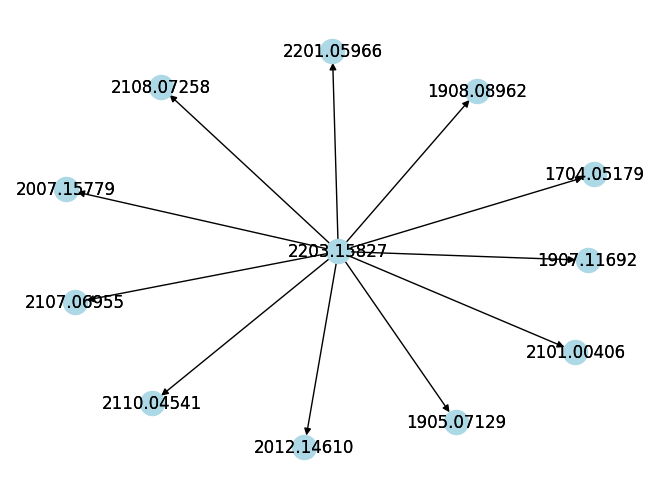

In [45]:
process_citation_graph('/work/articletest.pdf')

anchor segment, we may include documents of high
in-degree too often in the overall training data, los-
ing diversity. To adjust so that all documents appear
with a similar frequency in training, we sample a
linked document with probability inversely propor-
tional to its in-degree, as done in graph data mining
literature (Henzinger et al., 2000). We ﬁnd that this
technique yields a better LM performance (§5.5).
5 Experiments
We experiment with our proposed approach in the
general domain ﬁrst, where we pretrain LinkBERT
on Wikipedia articles with hyperlinks (§5.1) and
evaluate on a suite of downstream tasks (§5.2). We
compare with BERT (Devlin et al., 2019) as our base-
line. We experiment in the biomedical domain in §6.
5.1 Pretraining setup
Data. We use the same pretraining corpus used
by BERT: Wikipedia and BookCorpus (Zhu et al.,
2015). For Wikipedia, we use the WikiExtractor3to
extract hyperlinks between Wiki articles. We then
create training instances by sampling contiguous ,
ran

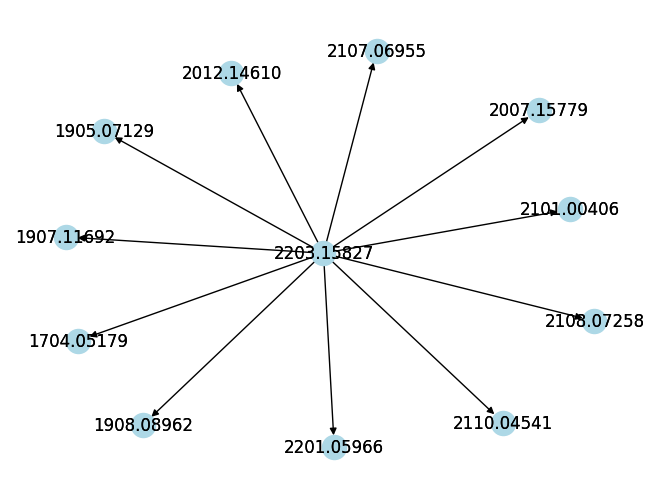

In [17]:
get_df_graph_citation_arXiv_only('/work/articletest.pdf')


# Test sur un mini corpus 

TactoFind: A Tactile Only System for Object Retrieval
Sameer Pai;1;2, Tao Chen;1;2, Megha Tippur;2, Edward Adelson2, Abhishek Guptay;1;2;3, Pulkit Agrawaly;1;2
1Improbable AI Lab2Massachusetts Institute of Technology3University of Washington
Authors contributed equally.yEqual Advising.
Abstract — We study the problem of object retrieval in scenar-
ios where visual sensing is absent, object shapes are unknown
beforehand and objects can move freely, like grabbing objects
out of a drawer. Successful solutions require localizing free
objects, identifying speciﬁc object instances, and then grasping
the identiﬁed objects, only using touch feedback. Unlike vision,
where cameras can observe the entire scene, touch sensors are
local and only observe parts of the scene that are in contact with
the manipulator. Moreover, information gathering via touch
sensors necessitates applying forces on the touched surface
which may disturb the scene itself. Reasoning with touch, there-
fore, requires ca

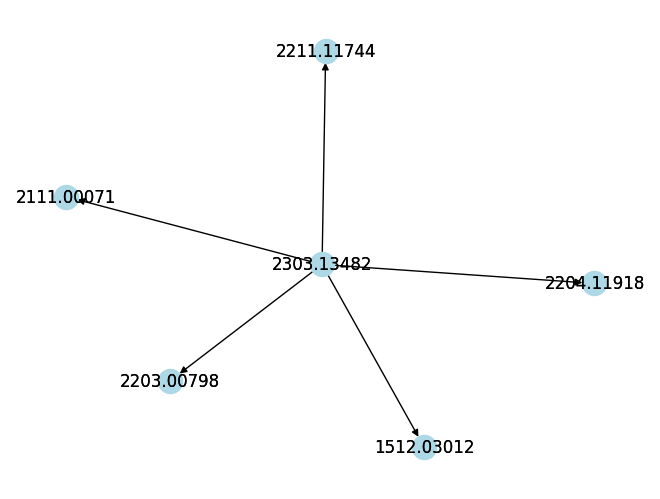

On Designing a Learning Robot: Improving Morphology
for Enhanced Task Performance and Learning
Maks Sorokin1;2, Chuyuan Fu1, Jie Tan3, C. Karen Liu4,
Yunfei Bai5, Wenlong Lu1, Sehoon Ha2, Mohi Khansari1
Abstract — As robots become more prevalent, optimizing their
design for better performance and efﬁciency is becoming
increasingly important. However, current robot design prac-
tices overlook the impact of perception and design choices
on a robot’s learning capabilities. To address this gap, we
propose a comprehensive methodology that accounts for the
interplay between the robot’s perception, hardware charac-
teristics, and task requirements. Our approach optimizes the
robot’s morphology holistically, leading to improved learning
and task execution proﬁciency. To achieve this, we introduce
a Morphology-AGnostIc Controller (MAGIC), which helps
with the rapid assessment of different robot designs. The
MAGIC policy is efﬁciently trained through a novel PRIvileged
Single-stage learning via

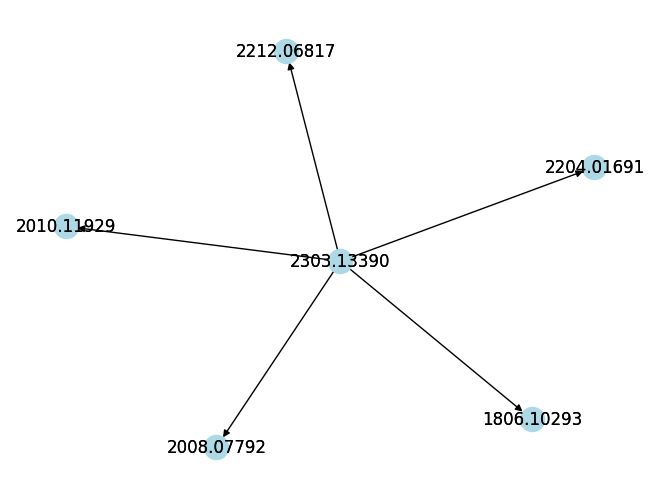

ERROR:tornado.application:Exception in callback functools.partial(<bound method OutStream._flush of <ipykernel.iostream.OutStream object at 0x7f72f963c310>>)
Traceback (most recent call last):
  File "/shared-libs/python3.9/py-core/lib/python3.9/site-packages/jupyter_client/session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode character '\ud835' in position 6017: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/shared-libs/python3.9/py-core/lib/python3.9/site-packages/tornado/ioloop.py", line 740, in _run_callback
    ret = callback()
  File "/shared-libs/python3.9/py-core/lib/python3.9/site-packages/ipykernel/iostream.py", line 518, in _flush
    self.session.send(
  File "/shared-libs/python3.9/py-core/lib/python3.9/site-packages/jupyter_client/session.py", line 848, in send
    to_send = self.serialize(msg, ident)
  File "/shared-libs/python3.9

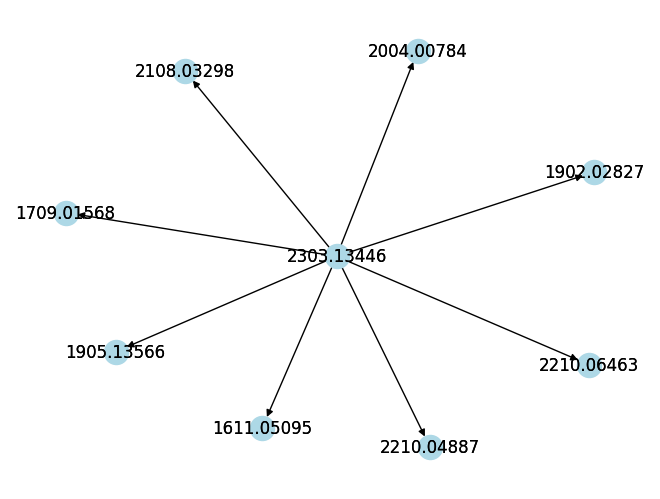

Covariance Steering for Uncertain Contact-rich Systems
Yuki Shiraiy, Devesh K. Jhaz, and Arvind U. Raghunathanz
Abstract — Planning and control for uncertain contact sys-
tems is challenging as it is not clear how to propagate
uncertainty for planning. Contact-rich tasks can be modeled
efﬁciently using complementarity constraints among other tech-
niques. In this paper, we present a stochastic optimization
technique with chance constraints for systems with stochastic
complementarity constraints. We use a particle ﬁlter-based
approach to propagate moments for stochastic complementarity
system. To circumvent the issues of open-loop chance con-
strained planning, we propose a contact-aware controller for
covariance steering of the complementarity system. Our opti-
mization problem is formulated as Non-Linear Programming
(NLP) using bilevel optimization. We present an important-
particle algorithm for numerical efﬁciency for the underlying
control problem. We verify that our contact-aware 

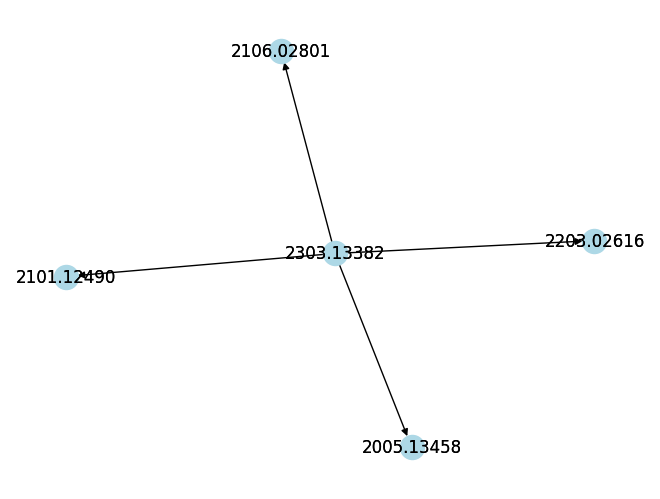

In [18]:
import os

# Chemin vers le dossier contenant les PDF
pdf_folder = '/work/Test'

# Liste pour stocker les graphes de citation
citation_graphs = []

# Boucle à travers les fichiers PDF dans le dossier
for filename in os.listdir(pdf_folder):
    if filename.endswith('.pdf'):
        # Chemin complet vers le fichier PDF
        filepath = os.path.join(pdf_folder, filename)

        # Appeler la fonction pour générer le graphe de citation
        citation_graph = get_df_graph_citation_arXiv_only(filepath)

        # Ajouter le graphe de citation à la liste
        citation_graphs.append(citation_graph)


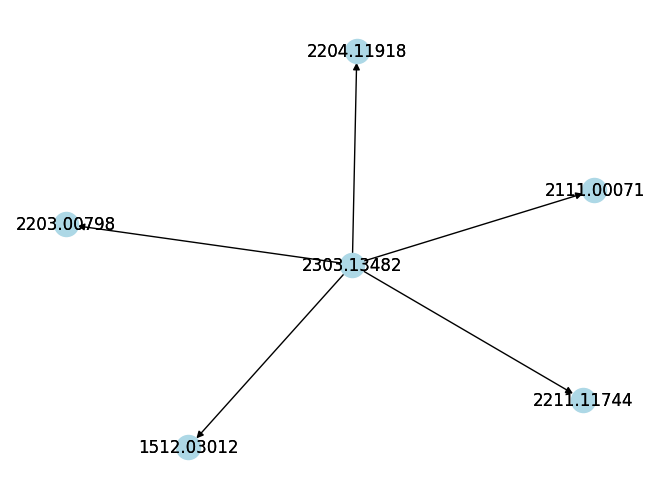

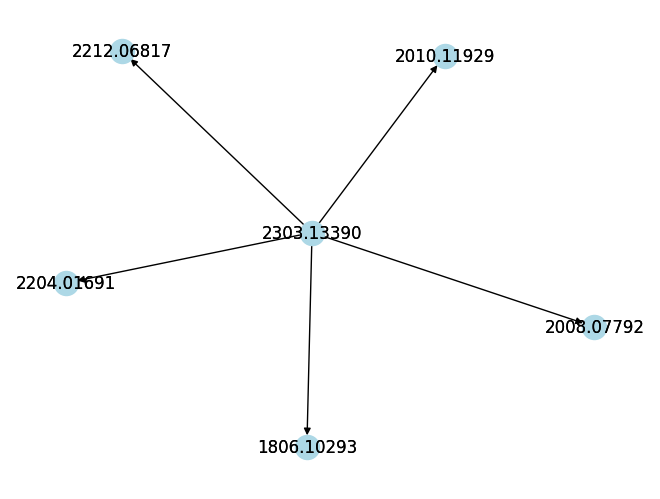

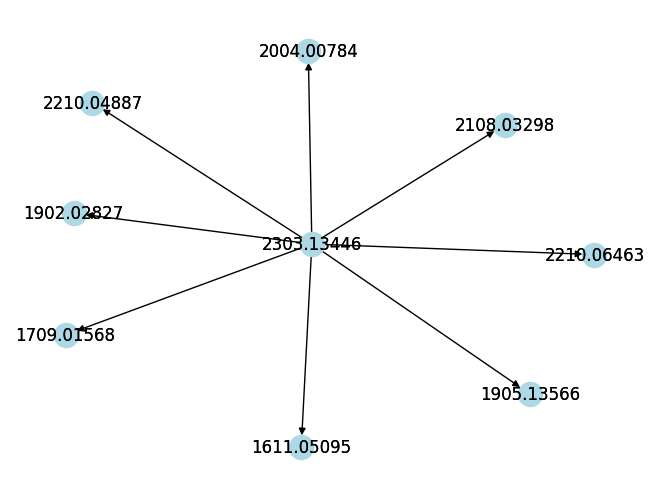

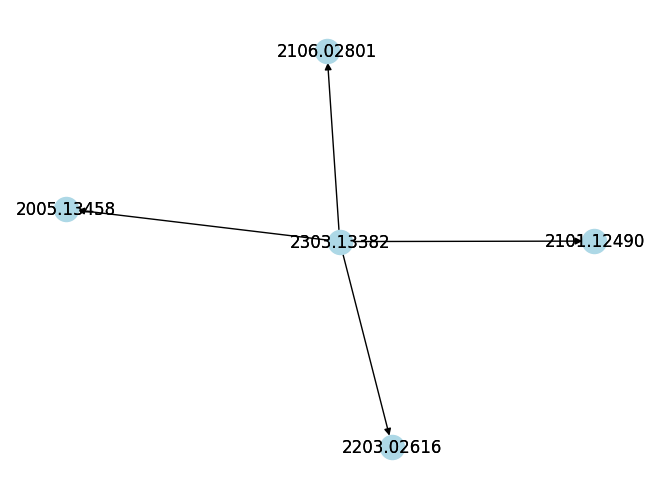

In [46]:
import os

# Chemin vers le dossier contenant les PDF
pdf_folder = '/work/Test'

# Liste pour stocker les graphes de citation
citation_graphs = []

# Boucle à travers les fichiers PDF dans le dossier
for filename in os.listdir(pdf_folder):
    if filename.endswith('.pdf'):
        # Chemin complet vers le fichier PDF
        filepath = os.path.join(pdf_folder, filename)

        # Appeler la fonction pour générer le graphe de citation
        citation_graph = process_citation_graph(filepath)

        # Ajouter le graphe de citation à la liste
        citation_graphs.append(citation_graph)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=61df9ec0-4810-4690-90cf-bbe4fbfededd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>